In [1]:
import pickle
import pybedtools
import os
import pandas as pd
import scanpy as sc
import numpy as np
from Bio import Entrez
import seaborn as sns
import kipoiseq
import matplotlib.pyplot as plt


/data/mikulik/miniconda3/envs/transformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data pre-processing for snRNA-seq data


1. Map all snRNA-seq counts for a gene to the gene's canonical TSS positions
2. Aggregate counts at cell type level to create cell type pseudobulks
3. libary size normalization -> divide by total counts in each cell type
4. Scale to median total counts
5. Create a target vector which contains the number of counts at the TSS and is zero everywhere else


In [2]:
data_dir = "/data/mikulik/mnt/gcs_basenj/"
#cage_path = "/data/mikulik/mnt/babraham_gastrulation/processed/rna"


Lets have a look at the mouse gastrulation scRNA-seq data set. Below you can see how many cells and genes are found in the count matrix. 

In [3]:
cage = sc.read_h5ad(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "anndata.h5ad"))
n_genes = cage.var.shape[0]
n_cells = cage.X.shape[0]
print(f"The RNA-seq data form mouse gastrualtion contains read counts from {n_cells} cells and {n_genes} genes.")
# The X matrix seems to contain the raw read counts
(cage.X[:5, :10]).todense()

The RNA-seq data form mouse gastrualtion contains read counts from 65420 cells and 32285 genes.


matrix([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 2., 0., 0., 1., 0.]], dtype=float32)

In [4]:
print(f"Sparsity of our RNA count data is : {np.round(cage.X.getnnz()/(cage.X.shape[0]* cage.X.shape[1]), decimals=4) * 100} %")

Sparsity of our RNA count data is : 13.4 %


Next we extract the canonical TSS for mouse. This file was downloaded from Biomart as described above. 

In [5]:
#mouse_tss = pd.read_csv(os.path.join(data_dir , "mouse_rna_seq_gastrulation_processing", "mart_export.txt"), sep=",", low_memory=False)
#mouse_tss.columns = ["gene_id", "version", "transcript_id", "stable","chr", "gene_start", "gene_end", "strand", "canonical", "gene_name", "transcript_type", "tss"]
#mouse_tss = mouse_tss[["gene_id", "transcript_id", "chr", "gene_start", "gene_end", "strand", "canonical", "gene_name", "transcript_type", "tss"]]
#mouse_tss = mouse_tss[mouse_tss.chr.isin(['18', '16', '19', '12', 'X', '13', '14', '8', '15', '3', '10', '6', '9', '17', '4', '1', '5', '11', '7', '2'])]
#assert mouse_tss.chr.nunique() == 20
#print(f"unique gene names: {mouse_tss.gene_name.nunique()}")
#print(f"from the gastrulation dataset we find {cage.var.gene.isin(mouse_tss.gene_name).sum()} genes out of {cage.var.shape[0]} genes")
#print(f"Unique gene ids: {mouse_tss.gene_id.nunique()}, unique transcript ids: {mouse_tss.transcript_id.nunique()}")


In [6]:
# biomart annotations
mouse_tss = pd.read_csv(os.path.join(data_dir , "mouse_rna_seq_gastrulation_processing", "grcm38_p6_biomart_gene_anno.txt"), sep="\t", low_memory=False)
mouse_tss.columns = ["gene_id", "stable_id", "transcript_id", "stable_transcript","chr", "strand", "tss", "gene_start", "gene_end", "transcript_start", "transcript_end", "gene_tyep", "gene_name"]
mouse_tss = mouse_tss[mouse_tss.chr.isin(['18', '16', '19', '12', 'X', '13', '14', '8', '15', '3', '10', '6', '9', '17', '4', '1', '5', '11', '7', '2'])]
assert mouse_tss.chr.nunique() == 20
print(f"unique gene names: {mouse_tss.gene_name.nunique()}")
print(f"from the gastrulation dataset we find {cage.var.gene.isin(mouse_tss.gene_name).sum()} genes out of {cage.var.shape[0]} genes")
print(f"Unique gene ids: {mouse_tss.gene_id.nunique()}, unique transcript ids: {mouse_tss.transcript_id.nunique()}")


unique gene names: 53685
from the gastrulation dataset we find 31161 genes out of 32285 genes
Unique gene ids: 53795, unique transcript ids: 140300


Ricard provides the unique TSSs online and that I can actually use those for my work as well. 

In [8]:
ann1 = pd.read_csv(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "feature_annotation", "GSM6205416_E7.5_rep1_GEX_features.tsv"), sep="\t", low_memory=False, header=None)
print(ann1.shape)
ann1.columns=["transcript_id", "gene_name", "feature_type", "chr", "start", "end"]
ann1 = ann1[ann1.transcript_id.str.contains("ENSMUSG")]
ann1["length"] = ann1.end - ann1.start
chr_list = []
for i in ['18', '16', '19', '12', 'X', '13', '14', '8', '15', '3', '10', '6', '9', '17', '4', '1', '5', '11', '7', '2']:
    chr_list.append(f"chr{i}")

ann1 = ann1[ann1.chr.isin(chr_list)]
print(f"Out of {ann1.shape[0]} genes , there are {ann1.transcript_id.isin(mouse_tss.gene_id).sum()} found in biomart annotation")


(232170, 6)
Out of 31470 genes , there are 31460 found in biomart annotation


In [9]:
# subset the anndata object to contain only genes for which there is an annotation
cage_sub = cage[:, cage.var.gene.isin(ann1.gene_name)]
anno = ann1[ann1.gene_name.isin(cage_sub.var.gene)]
anno = anno.drop_duplicates(subset=["gene_name"])
cage_sub.var.columns=["gene_name"]
print(cage_sub.shape, anno.shape)


(65420, 31440) (31440, 7)


Add the TSS gene annotations and coordinates to the count matrix.

In [12]:
# add the gene annotations to the anndata object
cage_sub.var = cage_sub.var.merge(anno, on="gene_name", how="left")
cage_sub.var

,gene_name,transcript_id,feature_type,chr,start,end,length
0,Xkr4,ENSMUSG00000051951,Gene Expression,chr1,3671497,3671498,1
1,Gm1992,ENSMUSG00000089699,Gene Expression,chr1,3466586,3466587,1
2,Gm19938,ENSMUSG00000102331,Gene Expression,chr1,3658903,3658904,1
3,Gm37381,ENSMUSG00000102343,Gene Expression,chr1,3985983,3986215,232
4,Rp1,ENSMUSG00000025900,Gene Expression,chr1,4360313,4409241,48928
...,...,...,...,...,...,...,...
31435,G530011O06Rik,ENSMUSG00000072844,Gene Expression,chrX,169978916,169978917,1
31436,Gm15726,ENSMUSG00000087263,Gene Expression,chrX,169985231,169985232,1
31437,Gm15247,ENSMUSG00000086695,Gene Expression,chrX,169986938,169986939,1
31438,Gm21887,ENSMUSG00000095562,Gene Expression,chrX,170009658,170010744,1086


#### Pseudobulk

Aggregating all counts for each cell type. 

In [22]:
n_celltypes, n_genes = cage_sub.obs.celltype.nunique(), cage_sub.var.shape[0]
print(f"Number of unique cell types: {n_celltypes}, number of unique genes: {n_genes}")

# empty matrix to store aggreagted counts
rna_agg = np.zeros((n_celltypes, n_genes))
# cell types
column_annotation = cage_sub.obs.celltype.unique()
# add cell index
cage_sub.obs["index"] = np.arange(cage_sub.obs.shape[0])
# group the cells by celltype
grouped_cells = cage_sub.obs.groupby("celltype")
rna_counts = cage_sub.X.todense()
# store the cell types in the correct order and write to anntoation fiel
rna_target_df = []
for i, celltype in enumerate(column_annotation):
    rna_target_df.append(celltype)
    # get the index of the cells that belong to the celltype
    index_celltype = grouped_cells.get_group(celltype)["index"].values
    # sum the read counts for each gene across all single cells of that cell type
    rna_agg[i, :] = rna_counts[index_celltype, :].sum(axis=0)


# write cell type annotations to file
rna_target_df = pd.DataFrame(rna_target_df)
rna_target_df.columns = ["celltype"]
#rna_target_df.to_csv(os.path.join(data_dir, "rna_targets_gastrulation_df.txt"))

Number of unique cell types: 37, number of unique genes: 31440


#### Normalization

1. **Library size normalization:** Divdide the counts of each gene in each cell type by the total number of counts in that cell type.
2. Scale by the median total number of counts across all celltypes
3. Log-transformation is optional (I save the aggregated counts without log-transform and apply it as neeeded later)

median total number of counts: 13946440.0


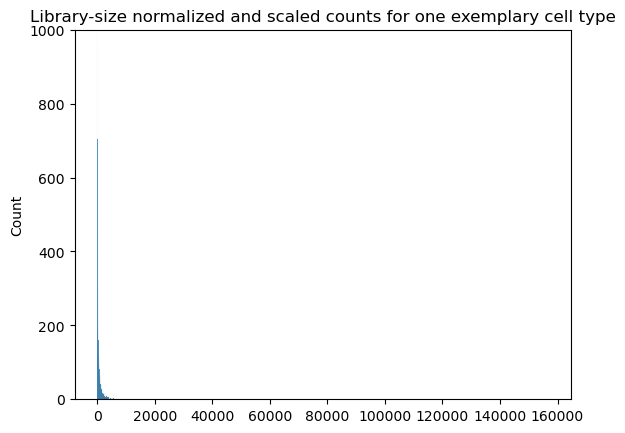

Text(0.5, 1.0, 'Library-size normalized, scaled and log-transformed counts for one exemplary cell type')

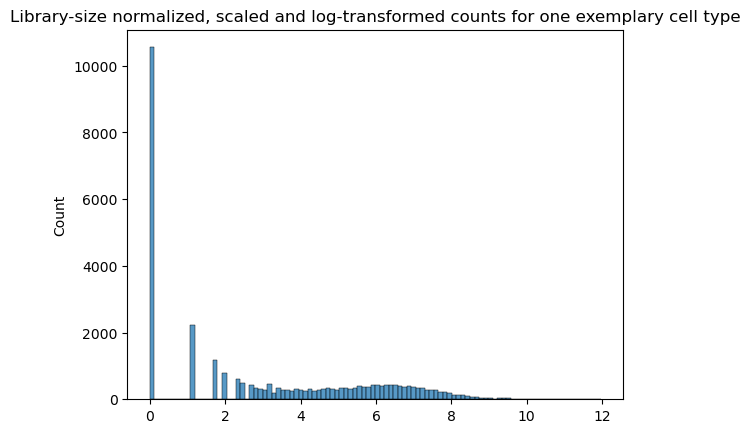

In [23]:
# divide by total counts
rna_lib = rna_agg / rna_agg.sum(axis=1)[:, None]
# Now the sum of each row (celltype) should be 1
assert all(np.isclose(rna_lib.sum(axis=1), 1))
# scale with median of total pseuobulk counts
print(f"median total number of counts: {np.median(rna_agg.sum(axis=1))}")
rna_lib_scaled = rna_lib * np.median(rna_agg.sum(axis=1))
# Now the sum of each row (celltype) should be equal to the median
assert all(np.isclose(rna_lib_scaled.sum(axis=1), np.median(rna_agg.sum(axis=1))))

# plot normalized data
sns.histplot(rna_lib_scaled[0, :])
plt.title("Library-size normalized and scaled counts for one exemplary cell type")
plt.ylim(0, 1000)
plt.show()

# plot log-normalized data
rna_lib_log = np.log(rna_lib_scaled + 1)
sns.histplot(rna_lib_log[0, :], bins=100)
plt.title("Library-size normalized, scaled and log-transformed counts for one exemplary cell type")


Now we are ready to create the sequence-target pairs for model training.

1. for each sequence of the train/test/valid data find all TSSs that overlap with the sequence
2. at the location of the TSS add the count value to the target vector (if there are no TSS overlapping with the sequence add only zero vector as targt)
3. write the target vector as np.file

First I get all genes from the mouse gastrualtion scRNA-seq dataset and write their TSS coordinates to a bed file.

In [13]:
# write tss coordiantes from mouse gastrulation to bed file
save = False
cage_sub.var["tss_end"] = cage_sub.var.start + 1
gene_df = cage_sub.var[["chr", "start", "tss_end", "transcript_id"]]
gene_df.columns = ["chrom", "start", "end", "gene_id"]
print(gene_df)
assert np.all(gene_df.gene_id.isin(cage_sub.var.transcript_id))
gene_bed = pybedtools.BedTool.from_dataframe(gene_df)
if save: 
    gene_bed.saveas(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "mouse_gastrulation_gene_tss.bed"))

      chrom      start        end             gene_id
0      chr1    3671497    3671498  ENSMUSG00000051951
1      chr1    3466586    3466587  ENSMUSG00000089699
2      chr1    3658903    3658904  ENSMUSG00000102331
3      chr1    3985983    3985984  ENSMUSG00000102343
4      chr1    4360313    4360314  ENSMUSG00000025900
...     ...        ...        ...                 ...
31435  chrX  169978916  169978917  ENSMUSG00000072844
31436  chrX  169985231  169985232  ENSMUSG00000087263
31437  chrX  169986938  169986939  ENSMUSG00000086695
31438  chrX  170009658  170009659  ENSMUSG00000095562
31439  chrX  170672643  170672644  ENSMUSG00000093806

[31440 rows x 4 columns]


Now we will write all input regions to a bed file. 

But first we need to crop to the center 114,688 bp, since we only make predictions for those, not all 131,072 bp.

In [14]:
print(f"bp we crop: {(131_072 - 114_688) / 2}")
print(f"bins we crop: {((131_072 - 114_688) / 2) / 128}")

bp we crop: 8192.0
bins we crop: 64.0


In [15]:
save = False
region_df = pd.read_csv(os.path.join(data_dir, "mouse", "sequences.bed"), sep="\t", header=None)
region_df.columns = ["chrom", "start", "end", "subset"]
region_df.reset_index(inplace=True)
region_df = region_df[["chrom", "start", "end", "subset", "index"]]
# crop to center 114,688 bp
crop_bp = int((131_072 - 114_688) / 2)
print(f"crop {crop_bp} bp")
region_df.start = region_df.start + crop_bp
region_df.end = region_df.end - crop_bp
assert np.all(region_df.end - region_df.start == 114_688)
region_bed = pybedtools.BedTool.from_dataframe(region_df)
if save:
    region_bed.saveas(os.path.join(data_dir,"mouse_rna_seq_gastrulation_processing", "mouse_input_sequences_basenji.bed"))

crop 8192 bp


The overlap between input regions and mouse gastrulation tss coordinates was computed on the cluster using: 
` python bedtools_overlap_karollus_tss.py mouse_gastrulation_gene_tss.bed mouse_input_sequences_basenji.bed overlap_mouse_gastrulation.bed /omics/groups/OE0540/internal/users/mikulik/master_thesis/data/gcs_basenj/mouse_rna_seq_gastrulation_processing`

In [16]:
overlap = pd.read_csv(os.path.join(data_dir, "mouse_rna_seq_gastrulation_processing", "overlap_mouse_gastrulation.bed"), sep="\t", header=None)
overlap.columns = ["gene_chr", "tss", "tss_end", "gene_id", "region_chr", "region_start", "region_end", "region_subset", "region_index", "overlap"]
overlap.dropna(inplace=True)

# compute distance in bp between start of input region and tss
overlap["distance"] = overlap["tss"] - overlap["region_start"]
assert np.all(overlap.distance >= 0)
assert np.all(overlap.distance <= 114_688)
# convert distance to bin position
overlap["bin"] = np.floor(overlap.distance / 128).astype(int)
assert np.all(overlap.bin >= 0)
assert np.all(overlap.bin <= 114_688 / 128)

assert np.all(overlap.gene_id.isin(cage_sub.var.transcript_id))
assert np.all(overlap.region_index.isin(region_df.index))
overlap

,gene_chr,tss,tss_end,gene_id,region_chr,region_start,region_end,region_subset,region_index,overlap,distance,bin
0,chr1,3671497,3671498,ENSMUSG00000051951,chr1,3601701,3716389,train,2723,1,69796,545
1,chr1,3671497,3671498,ENSMUSG00000051951,chr1,3667300,3781988,train,16918,1,4197,32
2,chr1,3466586,3466587,ENSMUSG00000089699,chr1,3404904,3519592,train,10889,1,61682,481
3,chr1,3658903,3658904,ENSMUSG00000102331,chr1,3601701,3716389,train,2723,1,57202,446
4,chr1,3985983,3985984,ENSMUSG00000102343,chr1,3929696,4044384,train,16557,1,56287,439
...,...,...,...,...,...,...,...,...,...,...,...,...
46306,chrX,169320279,169320280,ENSMUSG00000031352,chrX,169256525,169371213,valid,29480,1,63754,498
46307,chrX,169320621,169320622,ENSMUSG00000087159,chrX,169256525,169371213,valid,29480,1,64096,500
46308,chrX,169447829,169447830,ENSMUSG00000087587,chrX,169371214,169485902,valid,29568,1,76615,598
46309,chrX,169685198,169685199,ENSMUSG00000035299,chrX,169600592,169715280,valid,30039,1,84606,660


It is important to keep in mind that by overlapping the input sequences with the TSS coordinates we are not only loosing some input sequences, but also some genes that do not overlap with any input sequence!

In [17]:
print(f"Number of unique gene_ids in RNA-seq count matrx: {cage_sub.var.transcript_id.nunique()} and in the overlap datafram: {overlap.gene_id.nunique()}")
print(f"Are all gene ids foudn int he overlap dataframe? {np.all(cage_sub.var.transcript_id.isin(overlap.gene_id))}")
print(f"Are all gene ids found in the RNA-seq dataframe? {np.all(overlap.gene_id.isin(cage_sub.var.transcript_id))}")


Number of unique gene_ids in RNA-seq count matrx: 31440 and in the overlap datafram: 29241
Are all gene ids foudn int he overlap dataframe? False
Are all gene ids found in the RNA-seq dataframe? True


We want to create a sequence-target pair for each sequence in the input bed file. For each sequence we find all TSSs that overlap with the sequence and add the count value to the target vector. If there are no TSS overlapping with the sequence we add only a zero vector as targt.

In [18]:
def plot_tracks(tracks, interval, height=1.5):
    fig, axes = plt.subplots(len(tracks), 1, figsize=(20, height * len(tracks)), sharex=True)
    for ax, (title, y) in zip(axes, tracks.items()):
        ax.fill_between(np.linspace(interval.start, interval.end, num=len(y)), y)
        ax.set_title(title)
        sns.despine(top=True, right=True, bottom=True)
    ax.set_xlabel(str(interval))
    plt.tight_layout()
    plt.show()

       index  chrom      start        end subset  region_index
0          0   chr4   34114839   34229527  train             0
1          1   chr5   52215939   52330627  train             1
2          2  chr19   20145054   20259742  train             2
3          3  chr14   61853631   61968319  train             3
4          4  chr15    6600538    6715226  train             4
...      ...    ...        ...        ...    ...           ...
29290  29290   chr4  110577063  110691751  train         29290
29291  29291  chr18   49757509   49872197  train         29291
29292  29292  chr16   12692886   12807574  train         29292
29293  29293  chr17   36307991   36422679  train         29293
29294  29294  chr18   56448607   56563295  train         29294

[29295 rows x 6 columns]
index:0
ENSMUSG00000087602


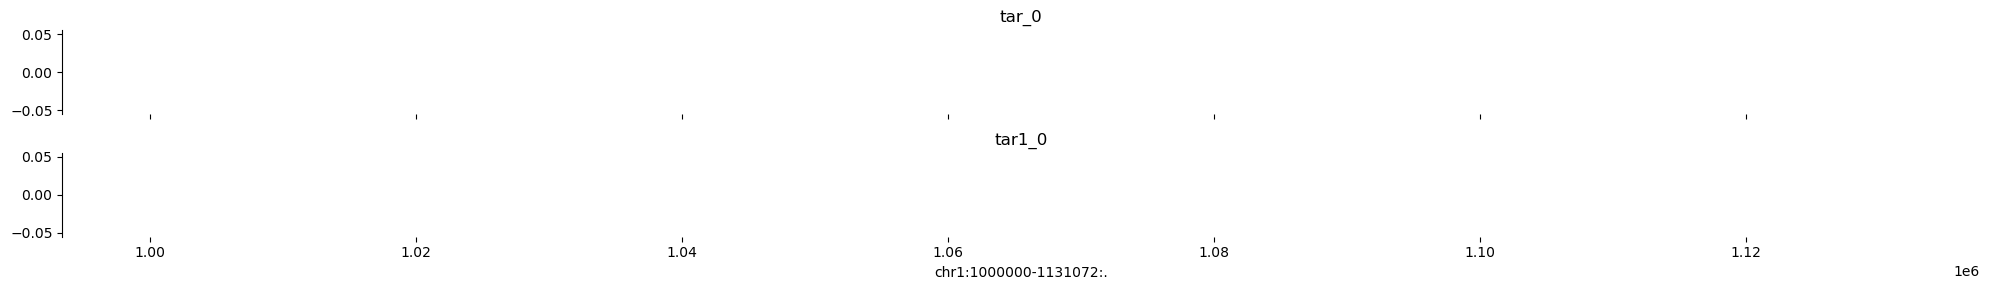

index:1
ENSMUSG00000106464


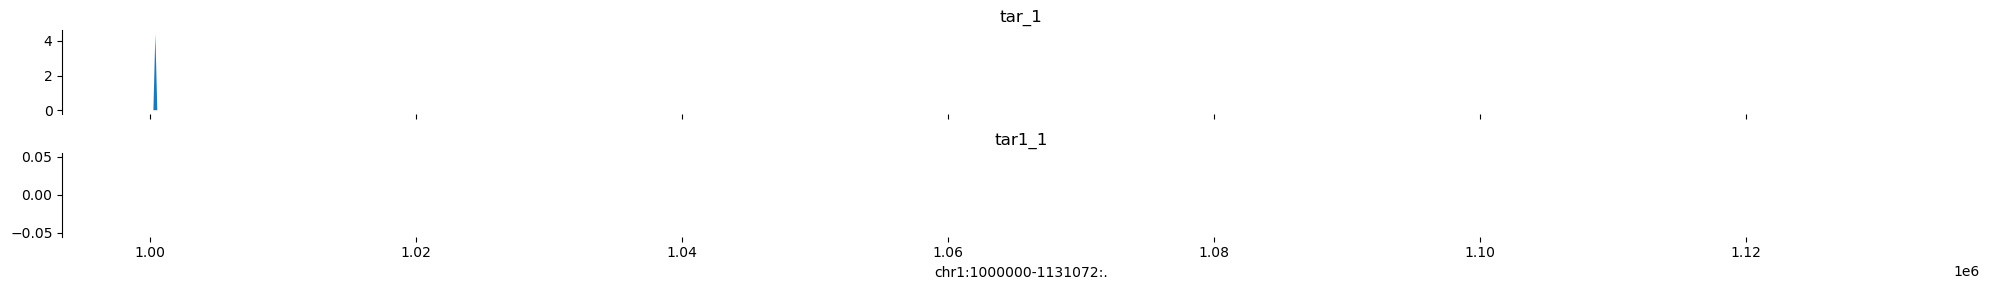

index:2


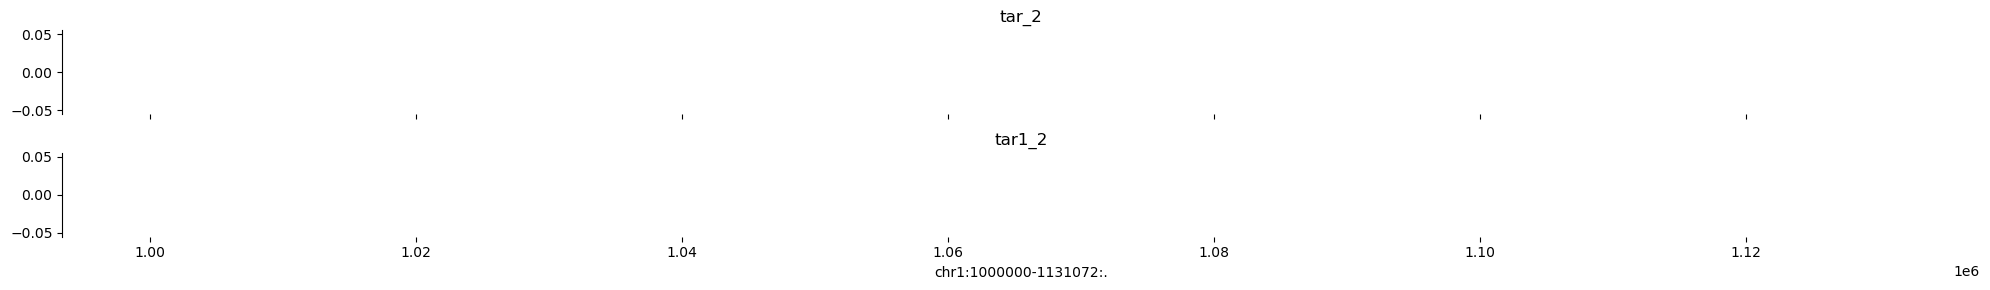

index:3


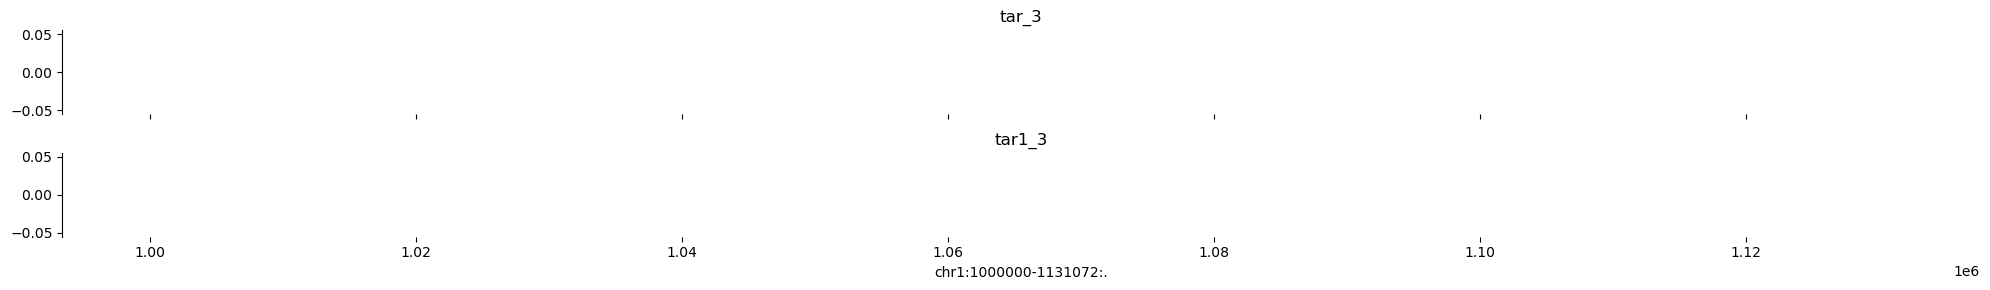

index:4
ENSMUSG00000089647
ENSMUSG00000050310


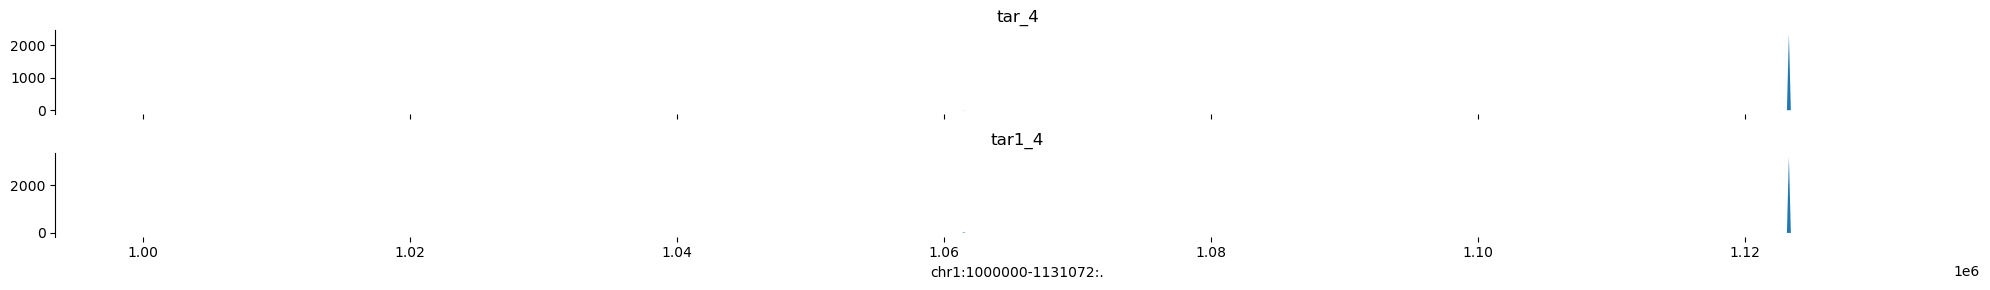

index:5
ENSMUSG00000065954


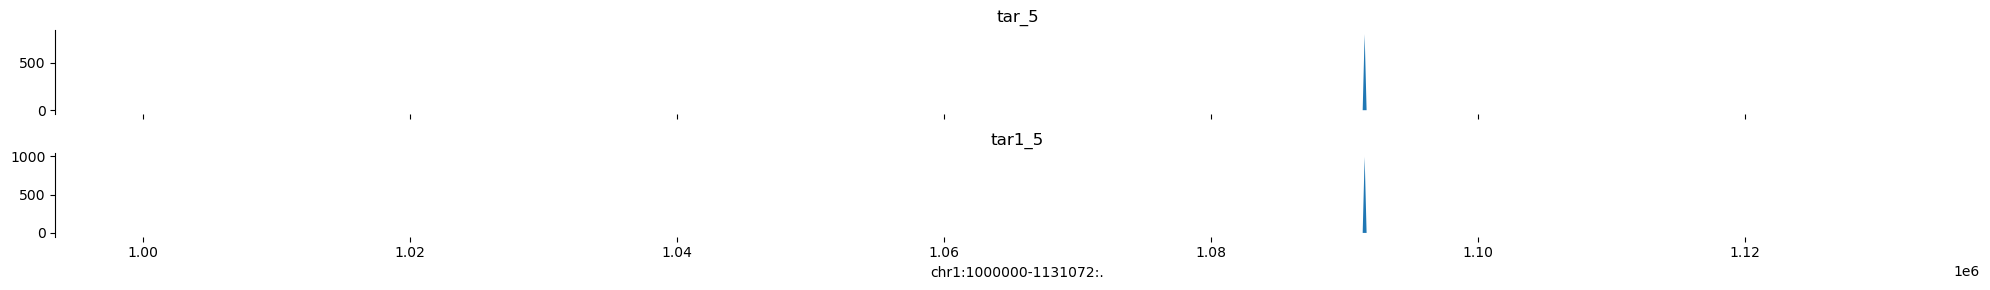

index:6
ENSMUSG00000028034
ENSMUSG00000039103


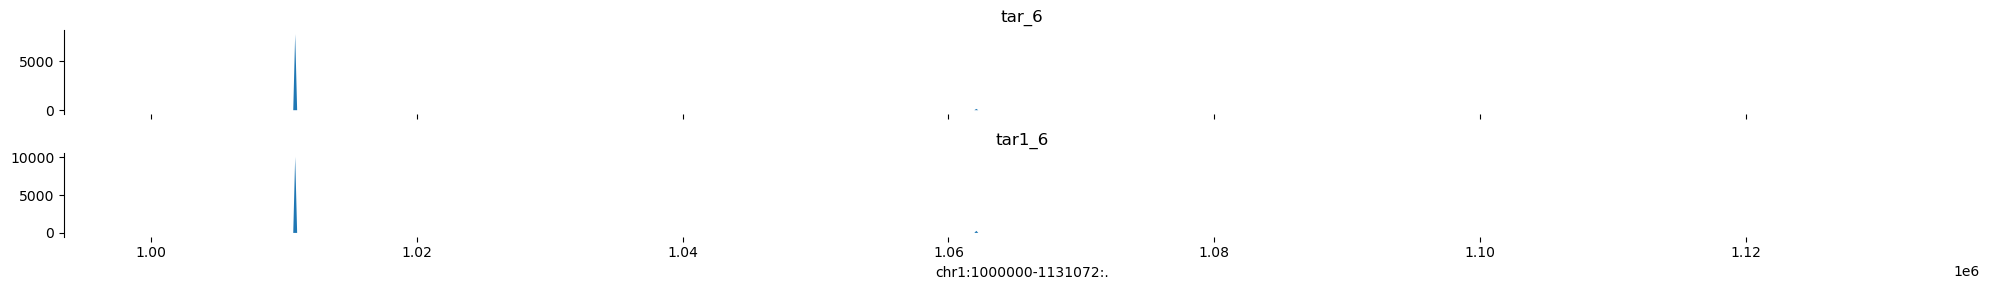

index:7
ENSMUSG00000020653
ENSMUSG00000062563


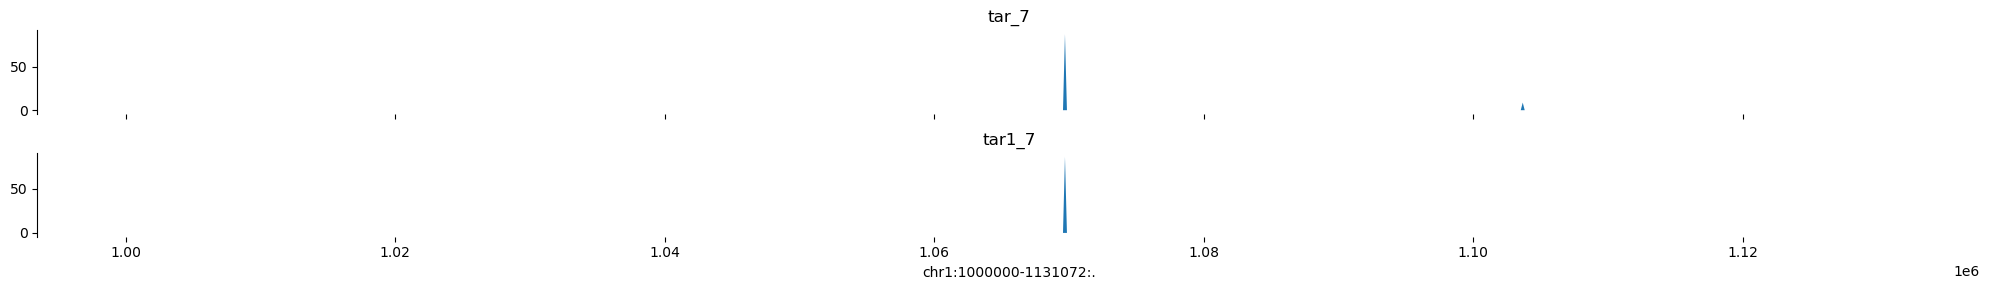

index:8
ENSMUSG00000033533
ENSMUSG00000109093
ENSMUSG00000108884
ENSMUSG00000047026
ENSMUSG00000030942


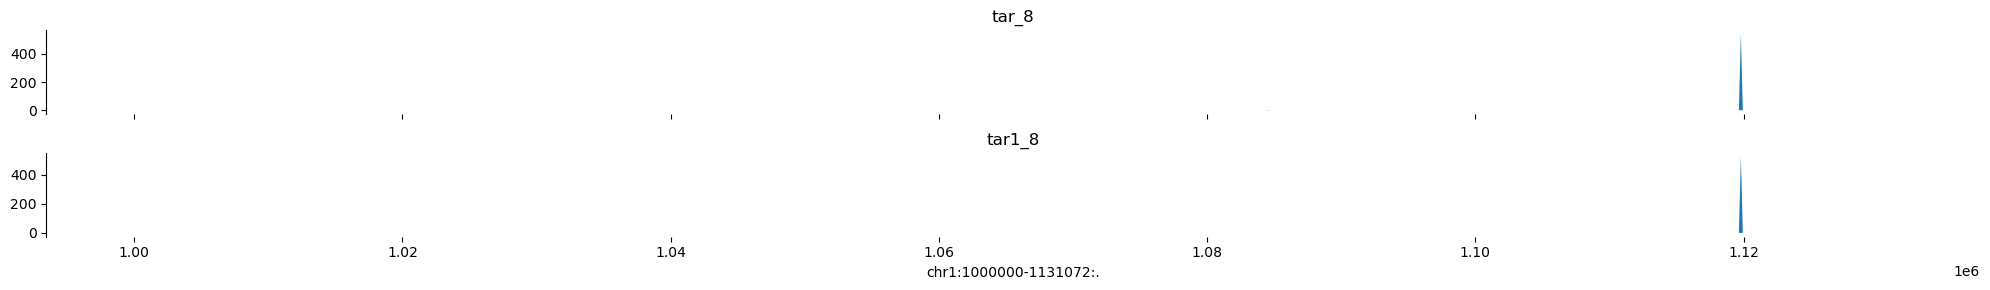

index:9
ENSMUSG00000002814
ENSMUSG00000049323
ENSMUSG00000020534
ENSMUSG00000042569


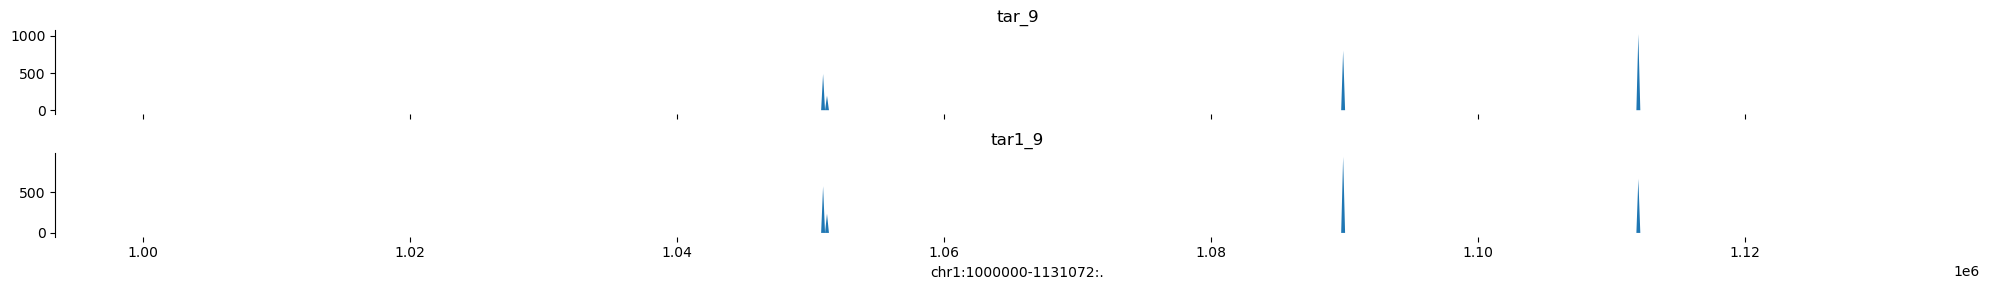

      index  chrom      start        end subset  region_index
0     31504   chr3   82141797   82256485   test         31504
1     31505   chrX   61212991   61327679   test         31505
2     31506  chr12   32677689   32792377   test         31506
3     31507  chr12  104164662  104279350   test         31507
4     31508   chr2   86630934   86745622   test         31508
...     ...    ...        ...        ...    ...           ...
2012  33516   chr2  110715624  110830312   test         33516
2013  33517  chr12   59945140   60059828   test         33517
2014  33518   chrX   56652266   56766954   test         33518
2015  33519   chrX   23604092   23718780   test         33519
2016  33520   chr2   86860312   86975000   test         33520

[2017 rows x 6 columns]
index:0
ENSMUSG00000033910


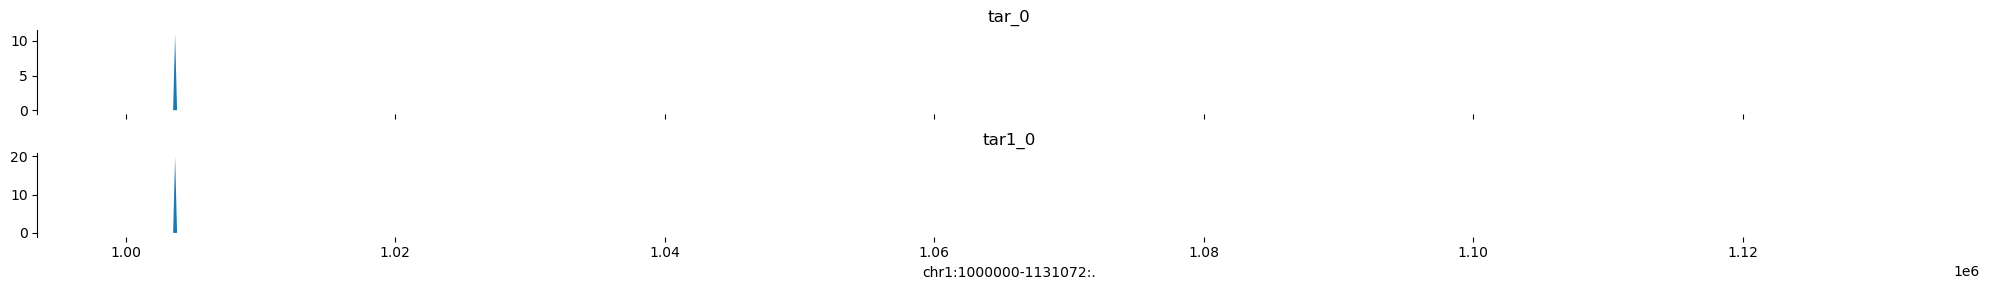

index:1


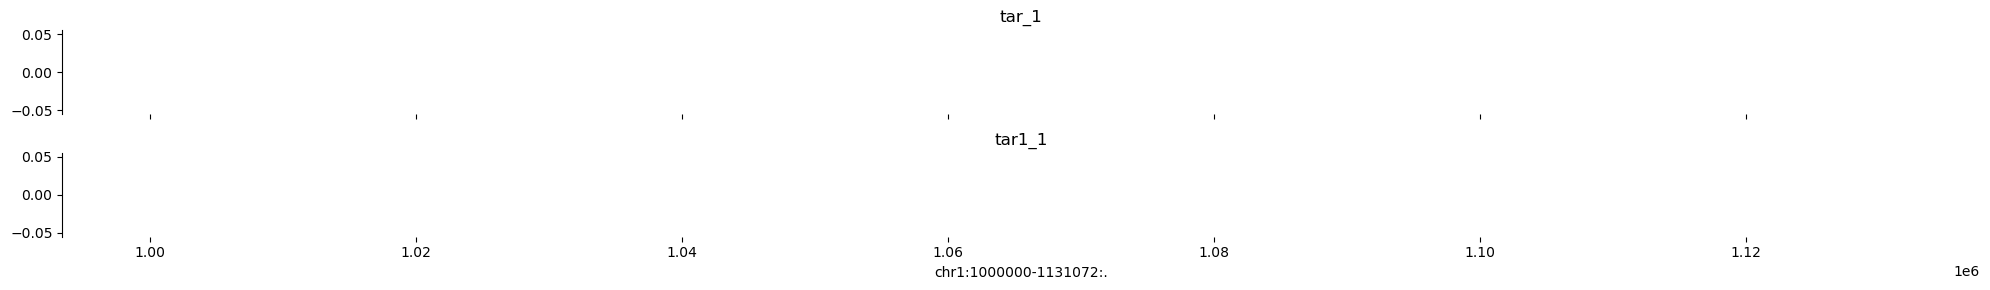

index:2


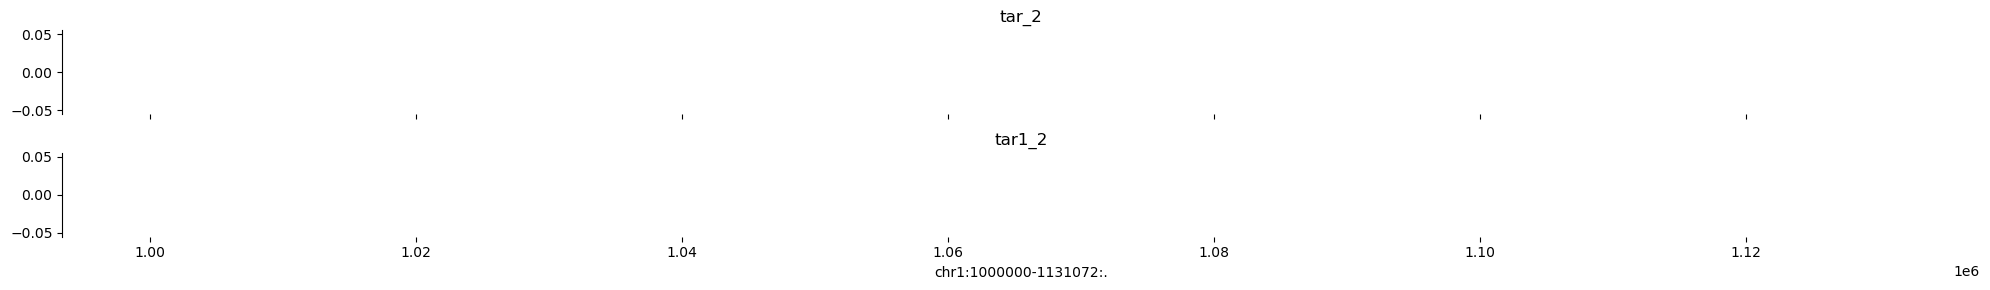

index:3
ENSMUSG00000066363
ENSMUSG00000041481
ENSMUSG00000079014


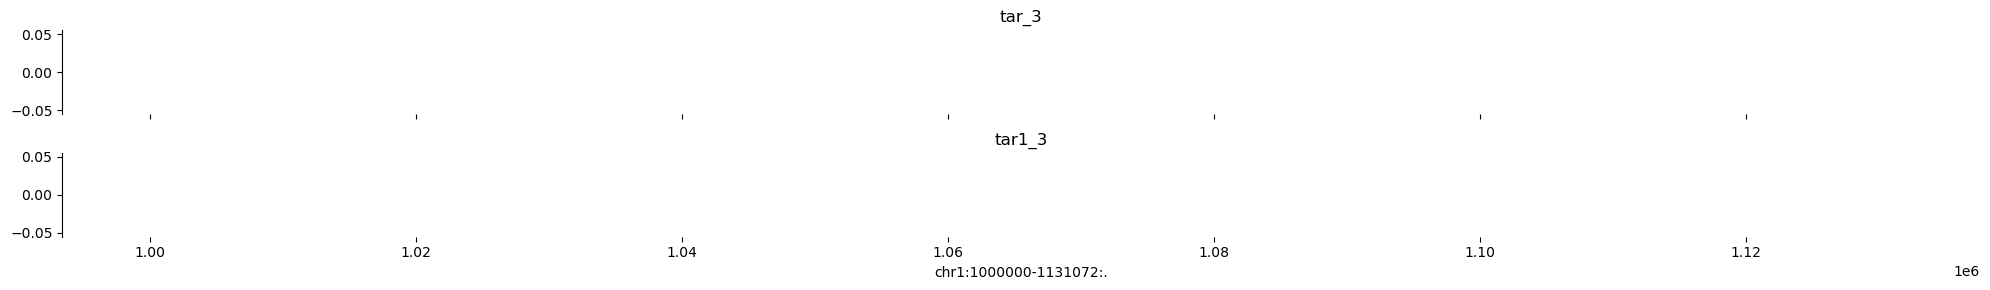

index:4
ENSMUSG00000110804
ENSMUSG00000075176
ENSMUSG00000075175
ENSMUSG00000075174
ENSMUSG00000111711


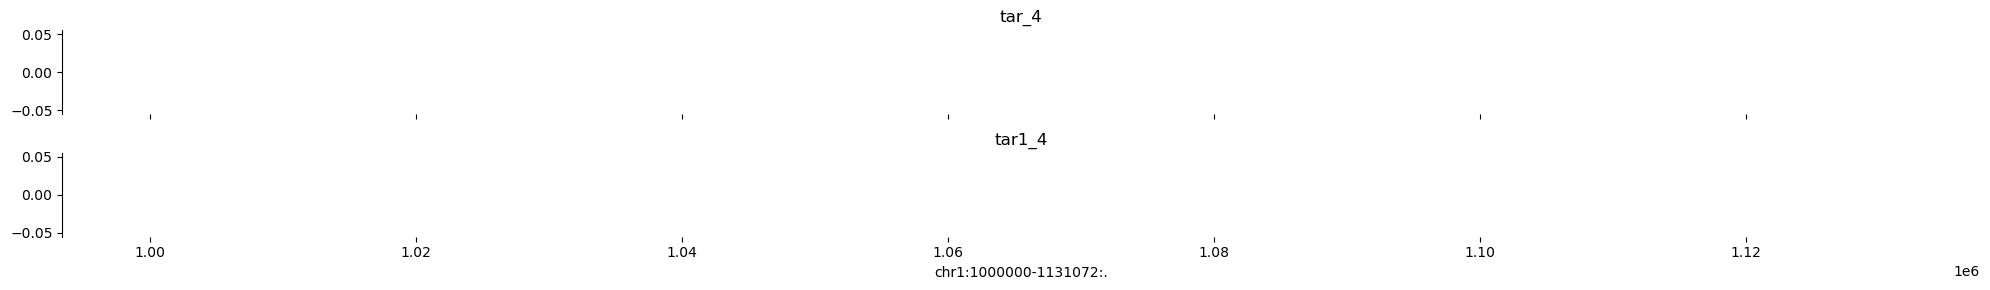

index:5
ENSMUSG00000116660
ENSMUSG00000022528


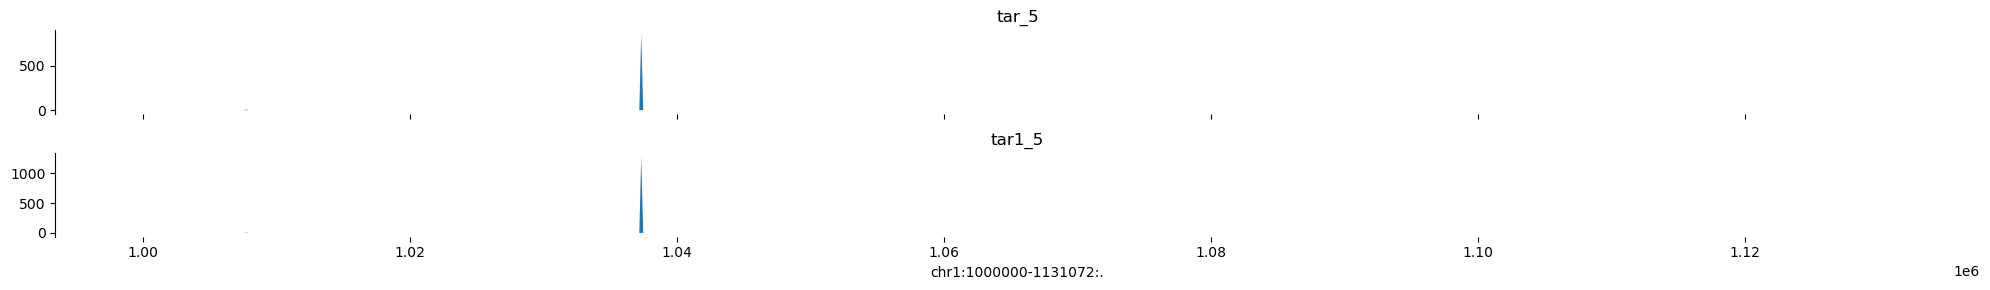

index:6


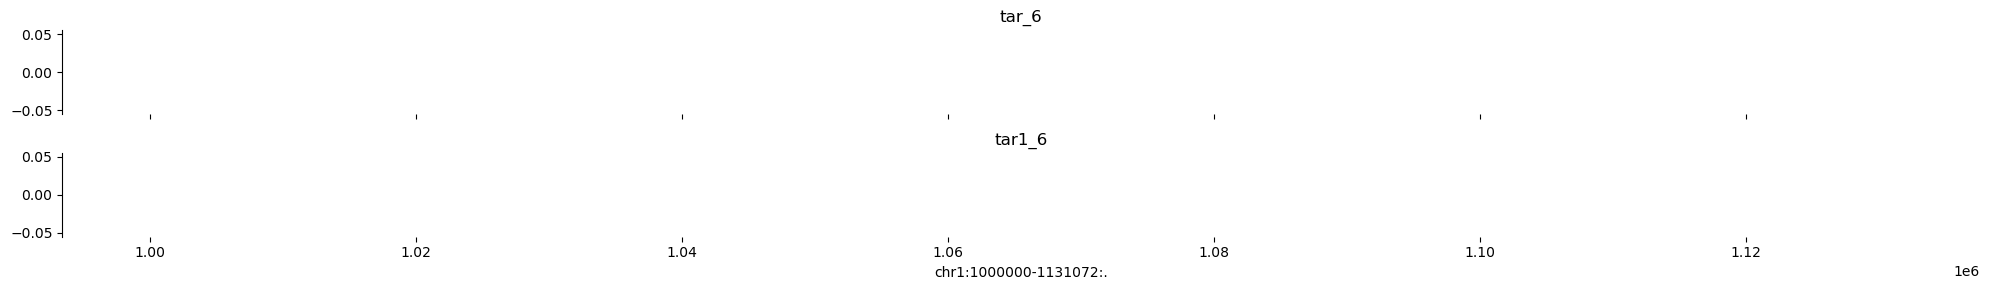

index:7


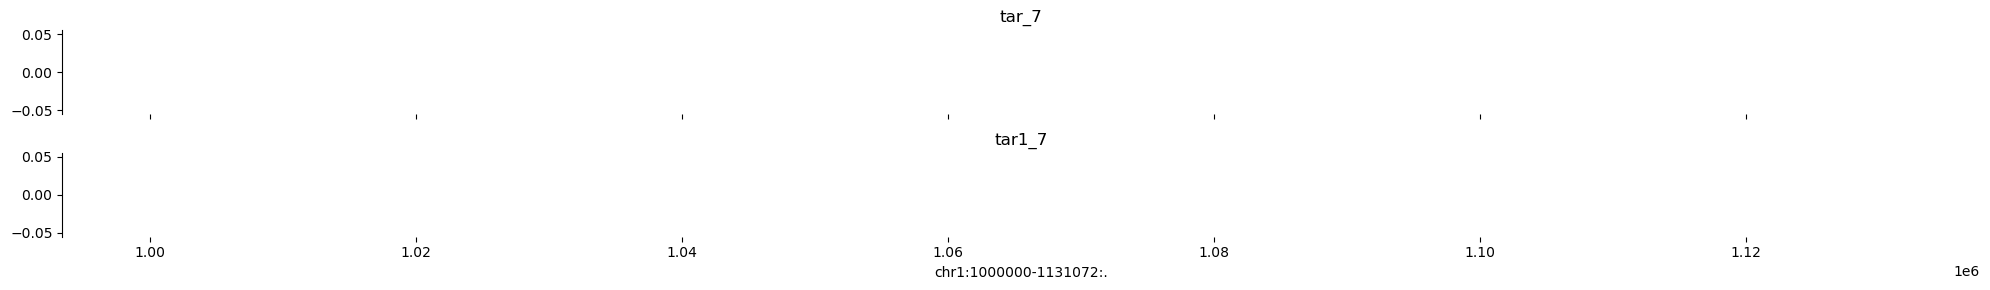

index:8
ENSMUSG00000095432
ENSMUSG00000097360
ENSMUSG00000058093
ENSMUSG00000021510


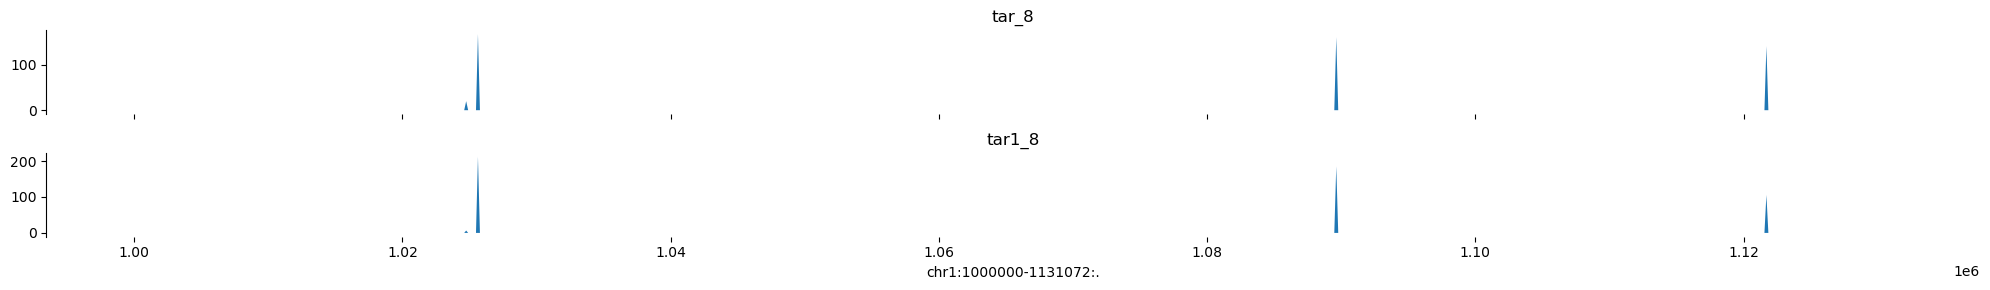

index:9
ENSMUSG00000027162


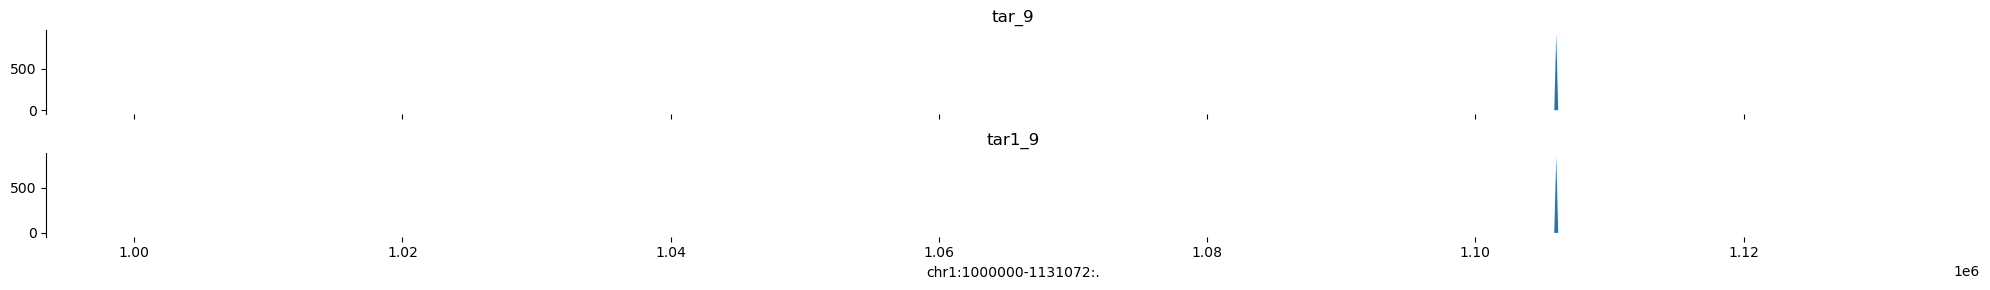

      index  chrom      start        end subset  region_index
0     29295   chrX  155837912  155952600  valid         29295
1     29296   chr1  110567593  110682281  valid         29296
2     29297  chr10    4380418    4495106  valid         29297
3     29298  chr17   17562230   17676918  valid         29298
4     29299   chr2  179557303  179671991  valid         29299
...     ...    ...        ...        ...    ...           ...
2204  31499   chr2  170008939  170123627  valid         31499
2205  31500   chrX   98531540   98646228  valid         31500
2206  31501  chr14  111925291  112039979  valid         31501
2207  31502   chrX   93258289   93372977  valid         31502
2208  31503   chrX  103348478  103463166  valid         31503

[2209 rows x 6 columns]
index:0


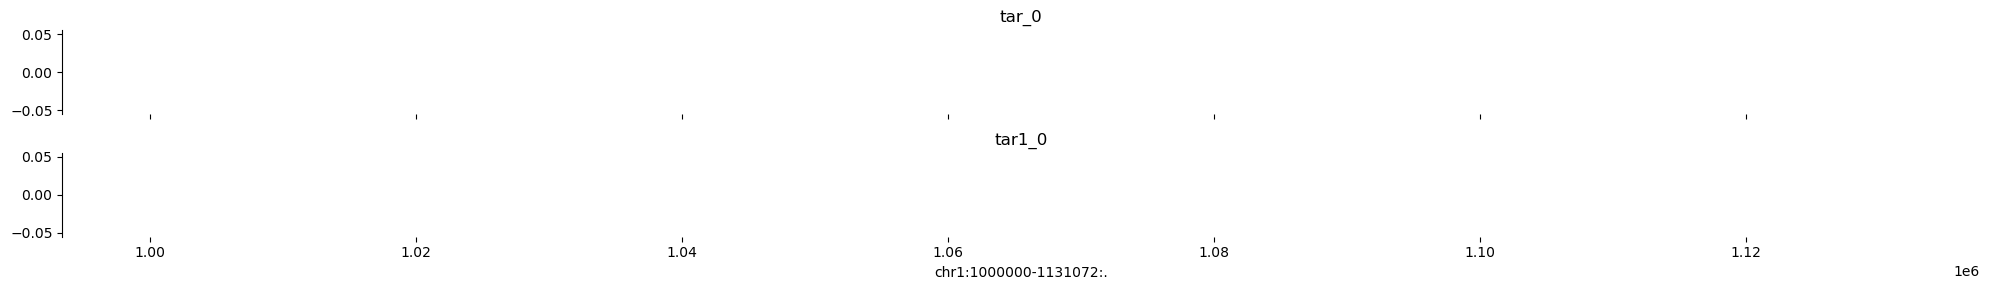

index:1


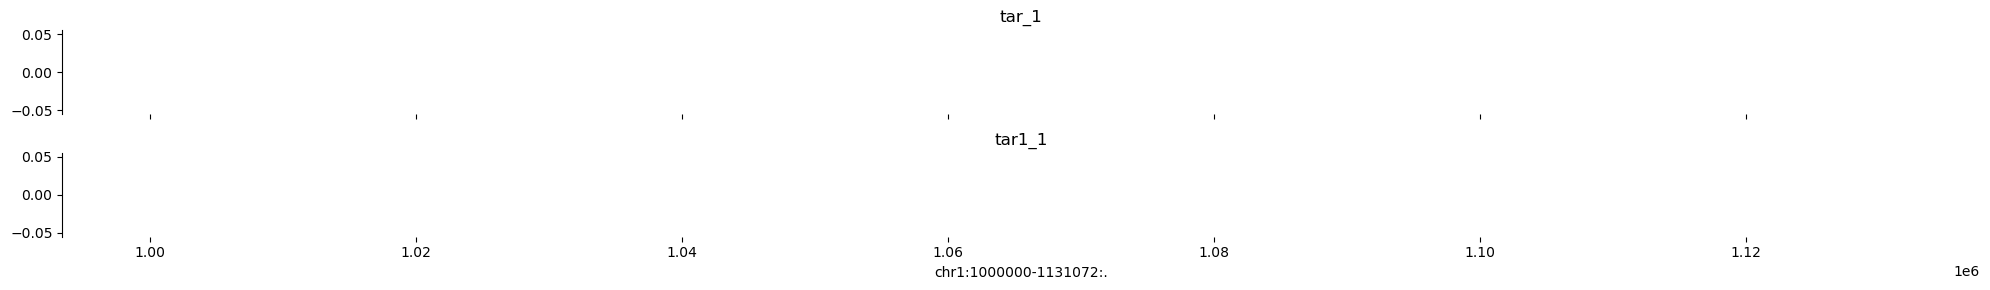

index:2
ENSMUSG00000075327
ENSMUSG00000095123
ENSMUSG00000019763
ENSMUSG00000085687
ENSMUSG00000061759
ENSMUSG00000019767


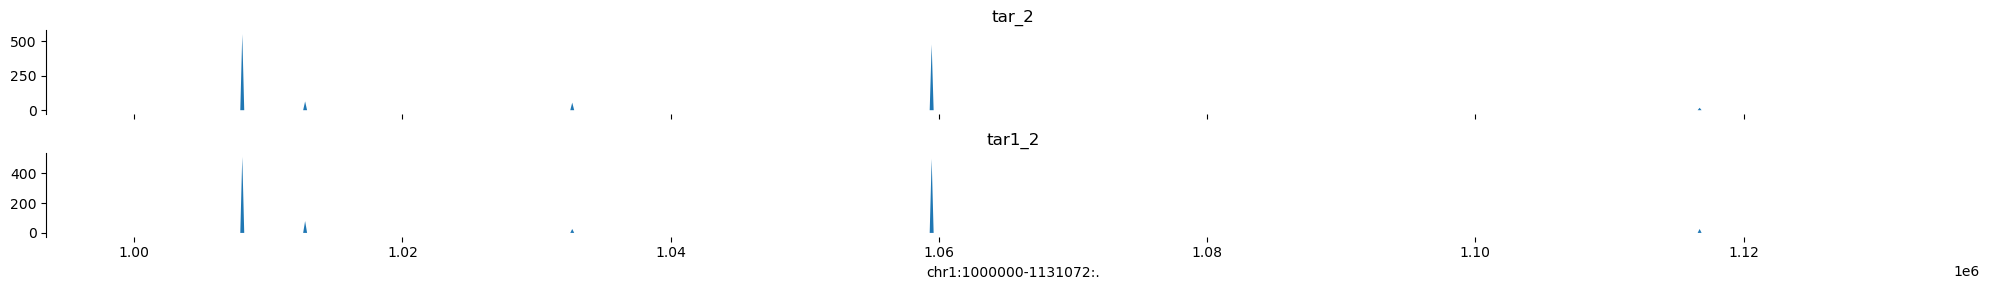

index:3
ENSMUSG00000023845


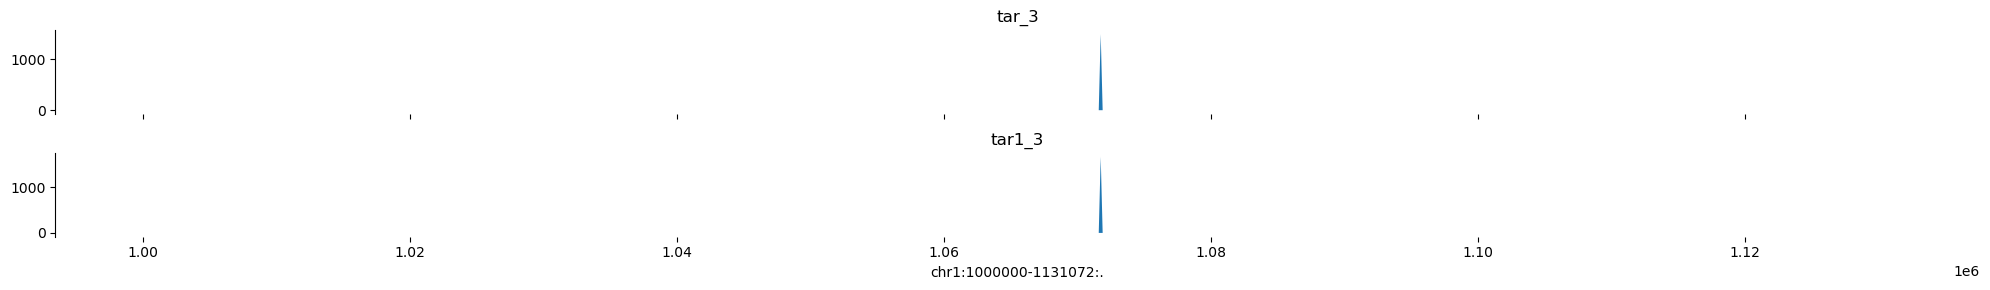

index:4


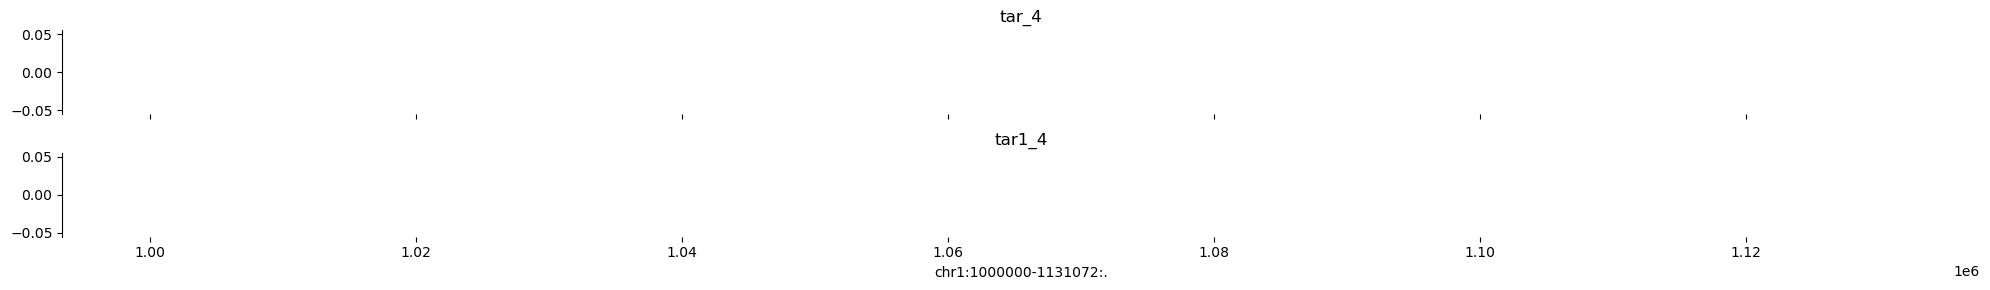

index:5


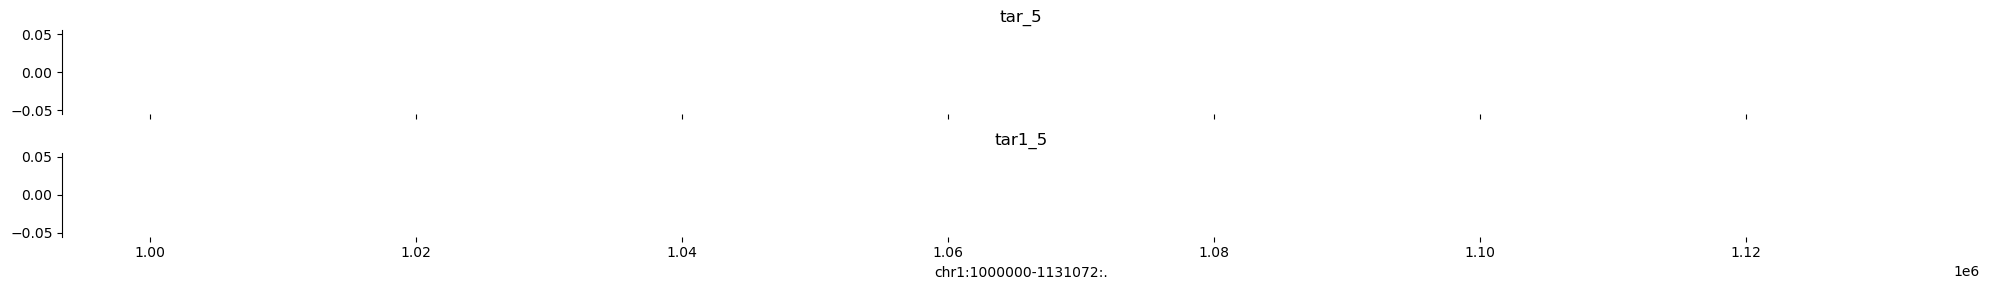

index:6


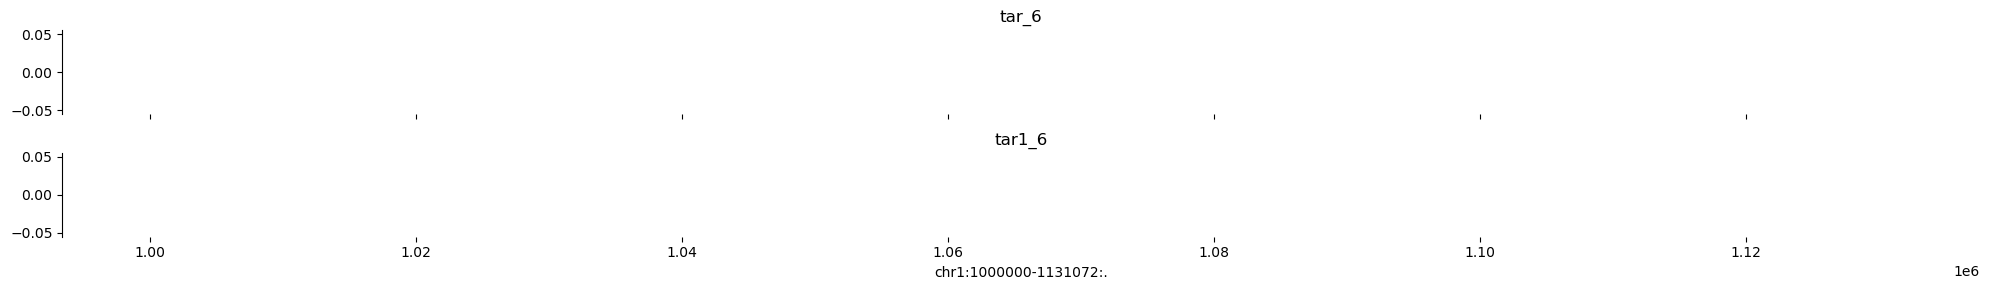

index:7


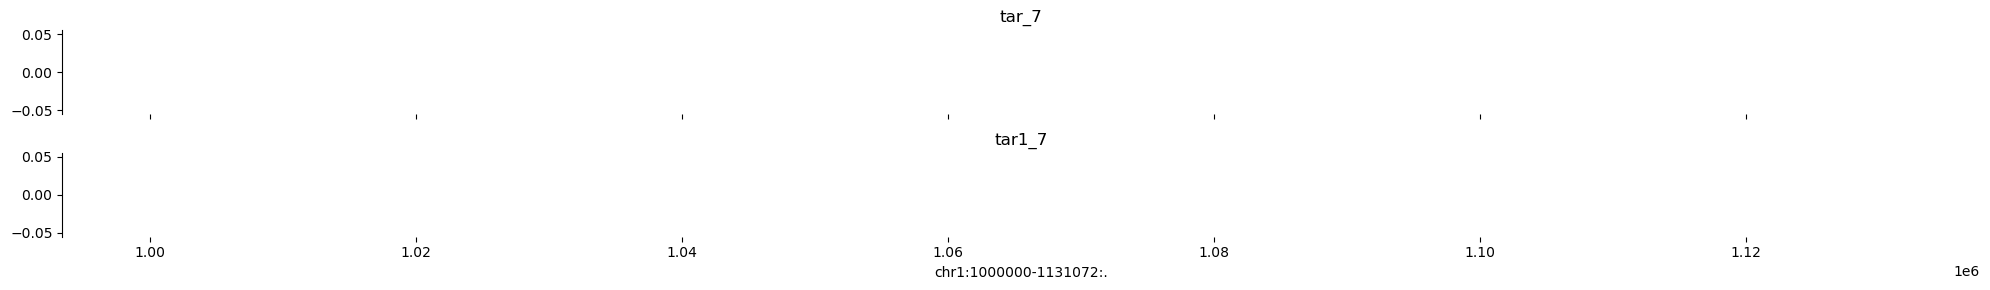

index:8
ENSMUSG00000034486
ENSMUSG00000092627
ENSMUSG00000067081


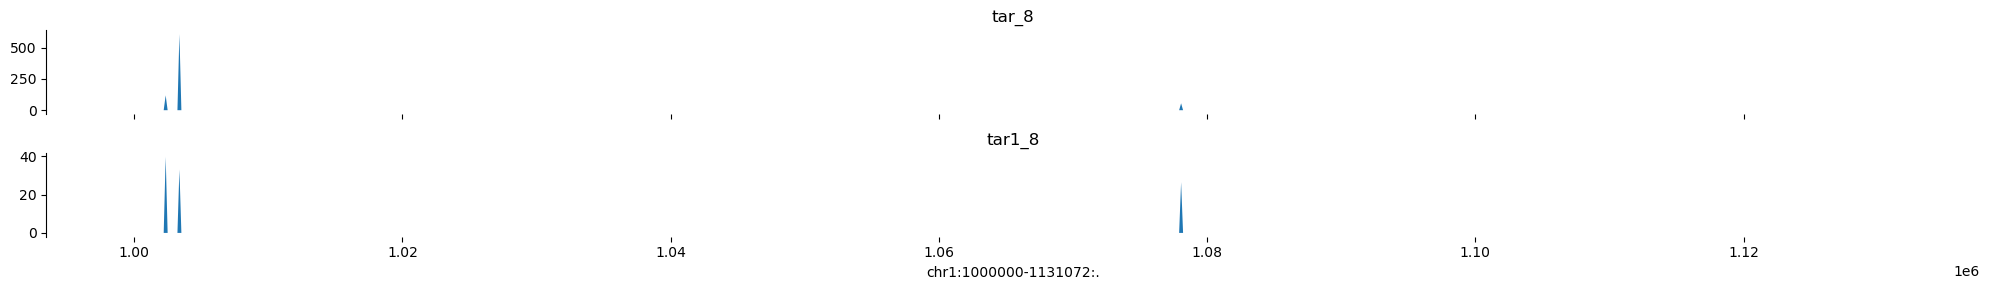

index:9


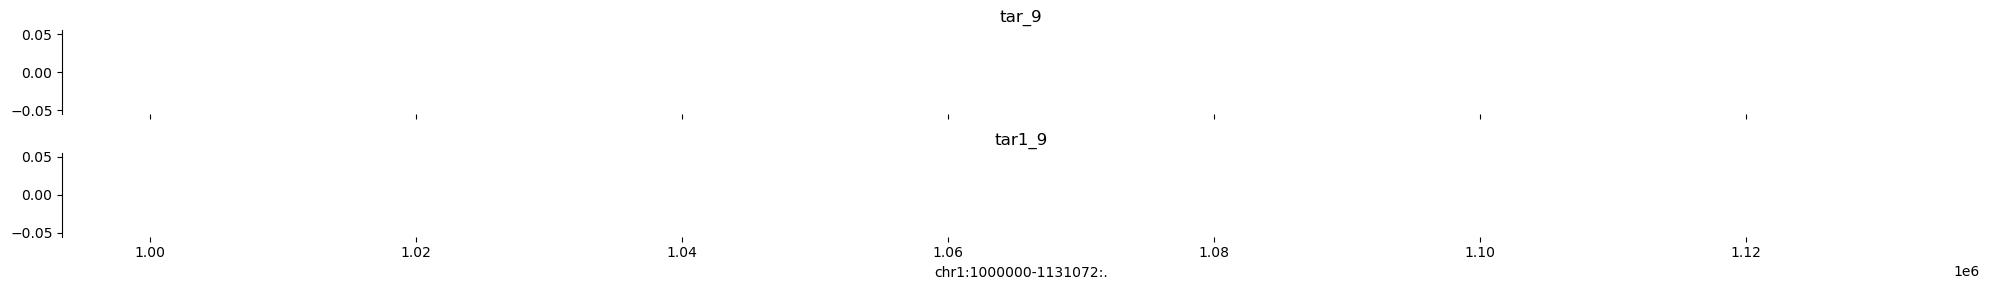

In [19]:
#double check that everything is working with some visualizations
for sub in ["train", "test", "valid"]:
    count = 0
    region_df.rename(columns={"index": "region_index"}, inplace=True)
    # get only regions that belong to current subset
    region_df_sub = region_df[region_df.subset == sub]
    # reset index for the subset of regions
    region_df_sub.reset_index(inplace=True)
    for i, region in region_df_sub.iterrows():
        print(f"index:{i}")
        count += 1
        # get the TSSs that overlap with the current region i
        overlap_sub = overlap[overlap.region_index == region.region_index]
        # create a target vector of shape #bins x #cell types
        target = np.zeros((896, rna_lib_scaled.shape[0]))
        # if at least one TSS overlaps with the current region, add the counts to the target vector at the corresponding bin
        if overlap_sub.shape[0] >= 1:
            # for each gene TSS, get the gene name, the corresponding index in the count matrix 
            # and add the counts to the target vector
            for j, row in overlap_sub.iterrows():
                gene_name = row.gene_id
                print(gene_name)
                gene_index = cage_sub.var[cage_sub.var.transcript_id == gene_name].index
                # add normalized counts to target vector at respective bin position
                target[row.bin, :] = rna_lib_scaled[:, gene_index].squeeze() 
                
        # create random target interval for th eplot
        target_interval = kipoiseq.Interval(chrom="chr1", start=1000000, end=1000000+131072)
        # plot counts for two exemplary cell types
        targets = {f"tar_{i}": target[:, 0].squeeze(), f"tar1_{i}": target[:, 2].squeeze()}
        plot_tracks(targets, target_interval)
        if count == 10:
            break

In [ ]:
# actually saving the targets to file
save = False
if save: 
    for sub in ["train", "test", "valid"]:
        count = 0
        region_df.rename(columns={"index": "region_index"}, inplace=True)
        # get only regions that belong to current subset
        region_df_sub = region_df[region_df.subset == sub]
        # reset index for the subset of regions
        region_df_sub.reset_index(inplace=True)
        for i, region in region_df_sub.iterrows():
            count += 1
            # get the TSSs that overlap with the current region i
            overlap_sub = overlap[overlap.region_index == region.region_index]
            # create a target vector of shape #bins x #cell types
            target = np.zeros((896, rna_lib_scaled.shape[0]))
            # if at least one TSS overlaps with the current region, add the counts to the target vector at the corresponding bin
            if overlap_sub.shape[0] >= 1:
                # for each gene TSS, get the gene name, the corresponding index in the count matrix 
                # and add the counts to the target vector
                for j, row in overlap_sub.iterrows():
                    gene_name = row.gene_id
                    gene_index = cage_sub.var[cage_sub.var.transcript_id == gene_name].index
                    # add normalized counts to target vector at respective bin position
                    target[row.bin, :] = rna_lib_scaled[:, gene_index].squeeze()

            np.save(os.path.join(data_dir, "basenji2_gastrulation_dataset_rna_grcm3_final", f"rna_{sub}-{i}.npy"), target)
